## Data ingestion

In [292]:
import duckdb
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from pathlib import Path

duckdb_path = "data/sakila.duckdb"
Path(duckdb_path).unlink(missing_ok=True)

with duckdb.connect(duckdb_path) as conn, open("sql/load_sakila.sql") as ingest_script:
    conn.sql(ingest_script.read())

    description = conn.sql("DESC;").df()
    films = conn.sql("FROM film;").df()

films.head(3)

,film_id,title,description,release_year,language_id,original_language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,last_update
0,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,<NA>,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2021-03-06 15:52:00
1,2,ACE GOLDFINGER,A Astounding Epistle of a Database Administrat...,2006,1,<NA>,3,4.99,48,12.99,G,"Trailers,Deleted Scenes",2021-03-06 15:52:00
2,3,ADAPTATION HOLES,A Astounding Reflection of a Lumberjack And a ...,2006,1,<NA>,7,2.99,50,18.99,NC-17,"Trailers,Deleted Scenes",2021-03-06 15:52:00


In [293]:
description["column_names"][7]

array(['film_id', 'title', 'description', 'release_year', 'language_id',
       'original_language_id', 'rental_duration', 'rental_rate', 'length',
       'replacement_cost', 'rating', 'special_features', 'last_update'],
      dtype=object)

# Task 1 - EDA in python

### Create a function to connect to sakila.duckdb and test it with assignment A - show title and length for movies longer than 3 hours:

In [294]:
def query_sakila(query: str, duckdb_path = "data/sakila.duckdb"):
    with duckdb.connect(duckdb_path) as conn:
        df = conn.sql(query=query).df()

    return df

query_sakila("""
            SELECT title, length 
            FROM film
            WHERE length > 180;
            """).head()

,title,length
0,ANALYZE HOOSIERS,181
1,BAKED CLEOPATRA,182
2,CATCH AMISTAD,183
3,CHICAGO NORTH,185
4,CONSPIRACY SPIRIT,184


### Which movies have the word "love" in its title? 

In [295]:
query_sakila("""SELECT title, rating, length, description
             FROM film
             WHERE regexp_matches(title, '(?i)(^|[^A-Za-z])LOVE([^A-Za-z]|$)');
             """).head()

,title,rating,length,description
0,GRAFFITI LOVE,PG,117,A Unbelieveable Epistle of a Sumo Wrestler And...
1,IDAHO LOVE,PG-13,172,A Fast-Paced Drama of a Student And a Crocodil...
2,INDIAN LOVE,NC-17,135,A Insightful Saga of a Mad Scientist And a Mad...
3,LAWRENCE LOVE,NC-17,175,A Fanciful Yarn of a Database Administrator An...
4,LOVE SUICIDES,R,181,A Brilliant Panorama of a Hunter And a Explore...


### Calculate the following statistics on movie length:
- shortest
- average
- median
- longest

In [296]:
query_sakila("""SELECT 
             ROUND(MIN(length), 0):: INTEGER as shortest_movie_min,
             ROUND(AVG(length), 0):: INTEGER AS average_movie_length_min,
             ROUND(MEDIAN(length), 0):: INTEGER AS median_movie_length_min,
             ROUND(MAX(length), 0):: INTEGER AS longest_movie_min
             FROM film
             """)

,shortest_movie_min,average_movie_length_min,median_movie_length_min,longest_movie_min
0,46,115,114,185


### Show the 10 most expensive movies to rent per day

In [297]:
query_sakila("""SELECT title, ROUND(rental_duration / rental_rate, 2) AS rent_per_day
             FROM film
             ORDER BY rent_per_day DESC;
             """).head(10)

,title,rent_per_day
0,GANDHI KWAI,7.07
1,SPIRIT FLINTSTONES,7.07
2,STORY SIDE,7.07
3,SHEPHERD MIDSUMMER,7.07
4,CRUELTY UNFORGIVEN,7.07
5,PRIMARY GLASS,7.07
6,UNFORGIVEN ZOOLANDER,7.07
7,CURTAIN VIDEOTAPE,7.07
8,NOTORIOUS REUNION,7.07
9,HOLLYWOOD ANONYMOUS,7.07


### Show the 10 actors who has played in most movies

In [298]:
query_sakila("""SELECT 
             a.first_name || ' ' || a.last_name AS actor,
             COUNT(DISTINCT f.film_id) AS number_of_movies
             FROM film f
                LEFT JOIN film_actor fa ON f.film_id = fa.film_id
                LEFT JOIN actor a ON a.actor_id = fa.actor_id
             GROUP BY actor
             ORDER BY number_of_movies DESC
            ;
             """).head(10)

,actor,number_of_movies
0,SUSAN DAVIS,54
1,GINA DEGENERES,42
2,WALTER TORN,41
3,MARY KEITEL,40
4,MATTHEW CARREY,39
5,SANDRA KILMER,37
6,SCARLETT DAMON,36
7,GROUCHO DUNST,35
8,UMA WOOD,35
9,ANGELA WITHERSPOON,35


### Questions:
- Where are the stores with most employees located?
- What are each store's top 5 categories of movies currently rented?
- Which store has the most active customers?
- On which day of the week are most films rented?

### Where are the stores with most employees located?

In [299]:
query_sakila("""SELECT 
             st.store_id AS store,
             c.city AS store_location,
             COUNT(staff_id) AS number_of_staff
             FROM staff s
                LEFT JOIN store st ON s.store_id = st.store_id
                LEFT JOIN address a ON st.address_id = a.address_id
                LEFT JOIN city c ON a.city_id = c.city_id
             GROUP BY store_location, store
             ;
             """)

,store,store_location,number_of_staff
0,1,Lethbridge,1
1,2,Woodridge,1


### What are each store's top 5 categories of movies currently rented?


In [300]:
query_sakila("""
            (           
             SELECT 
                s.store_id,
                c.name AS category_name,
                COUNT(*) AS number_of_rentals
             FROM store s
                LEFT JOIN inventory i ON i.store_id = s.store_id
                LEFT JOIN rental r ON r.inventory_id = i.inventory_id
                LEFT JOIN film f ON f.film_id = i.film_id
                LEFT JOIN film_category fc ON fc.film_id = f.film_id
                LEFT JOIN category c ON c.category_id = fc.category_id
             WHERE rental_date IS NOT NULL 
                AND return_date IS NULL
                AND s.store_id = 1
             GROUP BY s.store_id, c.name
             ORDER BY number_of_rentals DESC
             LIMIT 5
             )

            UNION ALL
            
            (
             SELECT 
                s.store_id,
                c.name AS category_name,
                COUNT(*) AS number_of_rentals
             FROM store s
                LEFT JOIN inventory i ON i.store_id = s.store_id
                LEFT JOIN rental r ON r.inventory_id = i.inventory_id
                LEFT JOIN film f ON f.film_id = i.film_id
                LEFT JOIN film_category fc ON fc.film_id = f.film_id
                LEFT JOIN category c ON c.category_id = fc.category_id
             WHERE rental_date IS NOT NULL 
                AND return_date IS NULL
                AND s.store_id = 2
             GROUP BY s.store_id, c.name
             ORDER BY number_of_rentals DESC
             LIMIT 5
             )
             ORDER BY store_id, number_of_rentals DESC
             ;
             """)


,store_id,category_name,number_of_rentals
0,1,Animation,12
1,1,Action,9
2,1,Music,8
3,1,Family,7
4,1,Sports,7
5,2,New,9
6,2,Horror,9
7,2,Animation,9
8,2,Sports,8
9,2,Action,8


### Which store has the most customers?

In [301]:
query_sakila("""SELECT 
            store_id,
            COUNT(active) AS active_customers
            FROM customer
            WHERE active = 1
            GROUP BY store_id
            ;
            """)

,store_id,active_customers
0,1,318
1,2,266


### On which day of the week in 2005 are most films rented?

In [302]:
query_sakila("""SELECT 
             strftime(rental_date, '%A') AS weekday,
             COUNT(rental_date) AS number_of_rentals,
             ROUND(number_of_rentals * 100.0 / SUM(number_of_rentals) OVER (), 1) || ' %' AS percentage
             FROM rental
             WHERE YEAR(rental_date) = 2005
             GROUP BY weekday
             ORDER BY number_of_rentals DESC
            ;
             """)

,weekday,number_of_rentals,percentage
0,Sunday,2320,14.6 %
1,Saturday,2311,14.6 %
2,Tuesday,2281,14.4 %
3,Friday,2272,14.3 %
4,Monday,2247,14.2 %
5,Wednesday,2231,14.1 %
6,Thursday,2200,13.9 %


# Task 2 - graphs

### Show the top 5 customers by total spend

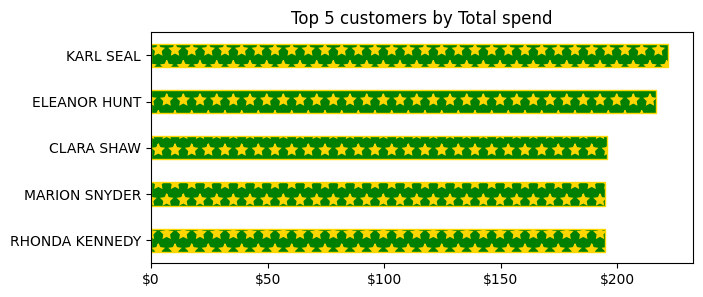

In [335]:
total_customer_spend = query_sakila("""SELECT 
             c.first_name || ' ' || c.last_name AS customer_name,
             SUM(p.amount) AS total_spend
             FROM payment p
                LEFT JOIN customer c ON p.customer_id = c.customer_id
             GROUP BY customer_name
             ORDER BY total_spend DESC
             ;
             """).head(5)

ax = total_customer_spend.plot(
    x="customer_name", 
    y="total_spend", 
    kind="barh",
    figsize=(7,3),
    color="green",
    hatch="*",
    edgecolor="gold",
    legend=False
    )

ax.invert_yaxis()

ax.set_ylabel("")

ax.xaxis.set_major_formatter(FuncFormatter(lambda v, _: f'${v:.0f}'))

ax.set_title("Top 5 customers by Total spend")

plt.show()